# ATP Tennis Data Exploration - REAL STATISTICS

This notebook explores ATP tennis match data from 2020-present with **REAL match statistics** from Tennis Abstract.

**Data includes:**
- Player information (name, hand, height, country)
- Match results with tournament details
- **REAL performance statistics** (aces, double faults, serve %, break points)
- Surface-specific analysis
- Ranking and points data

**Data Source**: Tennis Abstract (Jeff Sackmann GitHub)  
**No proxy metrics** - all statistics are from actual matches!

## 1. Import Required Libraries

In [6]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Libraries imported successfully!
Pandas version: 2.3.3
NumPy version: 2.4.0


## 2. Connect to SQLite Database

In [7]:
# Connect to database
db_path = 'tennis_data.db'
conn = sqlite3.connect(db_path)

# Verify connection and check tables
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table'")
tables = cursor.fetchall()

print(f"Connected to database: {db_path}")
print(f"\nAvailable tables: {[table[0] for table in tables]}")

# Get row counts
for table in tables:
    table_name = table[0]
    count = cursor.execute(f"SELECT COUNT(*) FROM {table_name}").fetchone()[0]
    print(f"  - {table_name}: {count:,} records")

Connected to database: tennis_data.db

Available tables: ['players', 'matches', 'sqlite_sequence', 'statistics']
  - players: 780 records
  - matches: 13,166 records
  - sqlite_sequence: 2 records
  - statistics: 25,242 records


## 3. Load Data from Database

In [8]:
# Load players
players_df = pd.read_sql_query("SELECT * FROM players", conn)
print(f"Players: {len(players_df)} unique players")
print(players_df.head())

# Load matches
matches_df = pd.read_sql_query("SELECT * FROM matches", conn)
matches_df['tournament_date'] = pd.to_datetime(matches_df['tournament_date'])
print(f"\nMatches: {len(matches_df)} total matches")
print(matches_df.head())

# Load statistics - NOW WITH REAL DATA!
stats_df = pd.read_sql_query("SELECT * FROM statistics", conn)
print(f"\n✅ Statistics: {len(stats_df)} total statistics records (REAL DATA!)")
print(f"Matches with statistics: {stats_df['match_id'].nunique()}")
if len(stats_df) > 0:
    print("\nSample statistics (REAL match data):")
    print(stats_df.head())
    print(f"\nStatistics columns: {list(stats_df.columns)}")
else:
    print("⚠️ No statistics found")

Players: 780 unique players
   player_id           player_name hand  height_cm country  \
0     100644      Alexander Zverev    R      198.0     GER   
1     102093           Martin Damm    L      203.0     USA   
2     103333          Ivo Karlovic    R      208.0     CRO   
3     103499            Aqeel Khan    R        NaN     PAK   
4     103529  Aisam Ul Haq Qureshi    R      183.0     PAK   

            created_at  
0  2025-12-27 14:30:58  
1  2025-12-27 14:31:02  
2  2025-12-27 14:30:58  
3  2025-12-27 14:30:59  
4  2025-12-27 14:30:59  

Matches: 13166 total matches
   match_id tourney_id tournament_name tournament_date surface  draw_size  \
0         1  2020-8888         Atp Cup      2020-01-06    Hard         24   
1         2  2020-8888         Atp Cup      2020-01-06    Hard         24   
2         3  2020-8888         Atp Cup      2020-01-06    Hard         24   
3         4  2020-8888         Atp Cup      2020-01-06    Hard         24   
4         5  2020-8888         Atp

## 4. Data Overview and Summary Statistics

In [9]:
# Match statistics
print("=== MATCH DATA SUMMARY ===\n")
print(f"Date range: {matches_df['tournament_date'].min()} to {matches_df['tournament_date'].max()}")
print(f"Total matches: {len(matches_df):,}")
print(f"\nMatches by surface:")
print(matches_df['surface'].value_counts())
print(f"\nMatches by tournament level:")
print(matches_df['tourney_level'].value_counts())

# Statistics coverage
print(f"\n=== REAL STATISTICS COVERAGE ===")
matches_with_stats = stats_df['match_id'].nunique()
print(f"Matches with detailed statistics: {matches_with_stats:,} ({matches_with_stats/len(matches_df)*100:.1f}%)")
print(f"Total statistics records: {len(stats_df):,}")

# Sample statistics
if len(stats_df) > 0:
    print(f"\n=== SAMPLE REAL STATISTICS ===")
    stats_sample = stats_df[stats_df['aces'].notna()].head(5)
    print(stats_sample[['match_id', 'player_id', 'is_winner', 'aces', 'double_faults', 
                        'first_serve_pct', 'first_serve_win_pct', 'break_point_save_pct']].to_string(index=False))

=== MATCH DATA SUMMARY ===

Date range: 2020-01-06 00:00:00 to 2024-12-18 00:00:00
Total matches: 13,166

Matches by surface:
surface
Hard     7884
Clay     3940
Grass    1289
Name: count, dtype: int64

Matches by tournament level:
tourney_level
A    7093
M    2582
G    2413
D     924
F      90
O      64
Name: count, dtype: int64

=== REAL STATISTICS COVERAGE ===
Matches with detailed statistics: 12,621 (95.9%)
Total statistics records: 25,242

=== SAMPLE REAL STATISTICS ===
 match_id  player_id  is_winner  aces  double_faults  first_serve_pct  first_serve_win_pct  break_point_save_pct
        1     104925          1    12              2         0.765625             0.836735              1.000000
        1     104745          0     5              3         0.728571             0.764706              0.750000
        2     105138          1     2              1         0.745763             0.659091              0.600000
        2     105583          0     2              1         0.61403

## 5. Join Data for Comprehensive Analysis

In [10]:
# Create comprehensive match view with player names and REAL statistics
query = """
SELECT 
    m.match_id,
    m.tournament_name,
    m.tournament_date,
    m.surface,
    m.tourney_level,
    m.round,
    pw.player_name as winner_name,
    pl.player_name as loser_name,
    m.winner_rank,
    m.loser_rank,
    m.winner_rank_points,
    m.loser_rank_points,
    m.minutes,
    m.score,
    sw.aces as w_aces,
    sw.double_faults as w_df,
    sw.first_serve_pct as w_1st_pct,
    sw.first_serve_win_pct as w_1st_win,
    sw.second_serve_win_pct as w_2nd_win,
    sw.break_point_save_pct as w_bp_save,
    sl.aces as l_aces,
    sl.double_faults as l_df,
    sl.first_serve_pct as l_1st_pct,
    sl.first_serve_win_pct as l_1st_win,
    sl.second_serve_win_pct as l_2nd_win,
    sl.break_point_save_pct as l_bp_save
FROM matches m
LEFT JOIN players pw ON m.winner_id = pw.player_id
LEFT JOIN players pl ON m.loser_id = pl.player_id
LEFT JOIN statistics sw ON m.match_id = sw.match_id AND sw.is_winner = 1
LEFT JOIN statistics sl ON m.match_id = sl.match_id AND sl.is_winner = 0
"""

matches_full = pd.read_sql_query(query, conn)
matches_full['tournament_date'] = pd.to_datetime(matches_full['tournament_date'])

print(f"Comprehensive match dataset: {len(matches_full)} matches")
print(f"Matches with REAL statistics: {matches_full['w_aces'].notna().sum()} ({matches_full['w_aces'].notna().sum()/len(matches_full)*100:.1f}%)")
print(f"\nColumns: {list(matches_full.columns)}")
print("\nSample data with REAL statistics:")
matches_full[matches_full['w_aces'].notna()].head(10)

Comprehensive match dataset: 13166 matches
Matches with REAL statistics: 12621 (95.9%)

Columns: ['match_id', 'tournament_name', 'tournament_date', 'surface', 'tourney_level', 'round', 'winner_name', 'loser_name', 'winner_rank', 'loser_rank', 'winner_rank_points', 'loser_rank_points', 'minutes', 'score', 'w_aces', 'w_df', 'w_1st_pct', 'w_1st_win', 'w_2nd_win', 'w_bp_save', 'l_aces', 'l_df', 'l_1st_pct', 'l_1st_win', 'l_2nd_win', 'l_bp_save']

Sample data with REAL statistics:


,match_id,tournament_name,tournament_date,surface,tourney_level,round,winner_name,loser_name,winner_rank,loser_rank,...,w_1st_pct,w_1st_win,w_2nd_win,w_bp_save,l_aces,l_df,l_1st_pct,l_1st_win,l_2nd_win,l_bp_save
0,1,Atp Cup,2020-01-06,Hard,A,F,Novak Djokovic,Rafael Nadal,2.0,1.0,...,0.765625,0.836735,0.600000,1.000000,5.0,3.0,0.728571,0.764706,0.315789,0.750000
1,2,Atp Cup,2020-01-06,Hard,A,F,Roberto Bautista Agut,Dusan Lajovic,10.0,34.0,...,0.745763,0.659091,0.666667,0.600000,2.0,1.0,0.614035,0.600000,0.272727,0.500000
2,3,Atp Cup,2020-01-06,Hard,A,SF,Novak Djokovic,Daniil Medvedev,2.0,5.0,...,0.675676,0.706667,0.444444,0.727273,6.0,5.0,0.527778,0.614035,0.490196,0.545455
3,4,Atp Cup,2020-01-06,Hard,A,SF,Dusan Lajovic,Karen Khachanov,34.0,17.0,...,0.716418,0.791667,0.736842,NaN,9.0,3.0,0.683544,0.722222,0.560000,0.000000
4,5,Atp Cup,2020-01-06,Hard,A,SF,Rafael Nadal,Alex De Minaur,1.0,18.0,...,0.726190,0.786885,0.434783,0.333333,6.0,1.0,0.733333,0.672727,0.500000,0.200000
5,6,Atp Cup,2020-01-06,Hard,A,SF,Roberto Bautista Agut,Nick Kyrgios,10.0,29.0,...,0.771930,0.795455,0.538462,1.000000,13.0,1.0,0.690909,0.578947,0.470588,0.571429
6,7,Atp Cup,2020-01-06,Hard,A,QF,Novak Djokovic,Denis Shapovalov,2.0,14.0,...,0.603774,0.718750,0.571429,0.714286,15.0,7.0,0.517647,0.818182,0.463415,0.400000
7,8,Atp Cup,2020-01-06,Hard,A,QF,Dusan Lajovic,Felix Auger Aliassime,34.0,21.0,...,0.758065,0.744681,0.533333,1.000000,10.0,5.0,0.661765,0.688889,0.304348,0.727273
8,9,Atp Cup,2020-01-06,Hard,A,QF,Daniil Medvedev,Diego Schwartzman,5.0,13.0,...,0.660194,0.779412,0.371429,0.800000,1.0,3.0,0.682927,0.642857,0.615385,0.400000
9,10,Atp Cup,2020-01-06,Hard,A,QF,Karen Khachanov,Guido Pella,17.0,25.0,...,0.730159,0.847826,0.411765,0.833333,3.0,4.0,0.553846,0.666667,0.482759,0.400000


## 6. Top Players Analysis

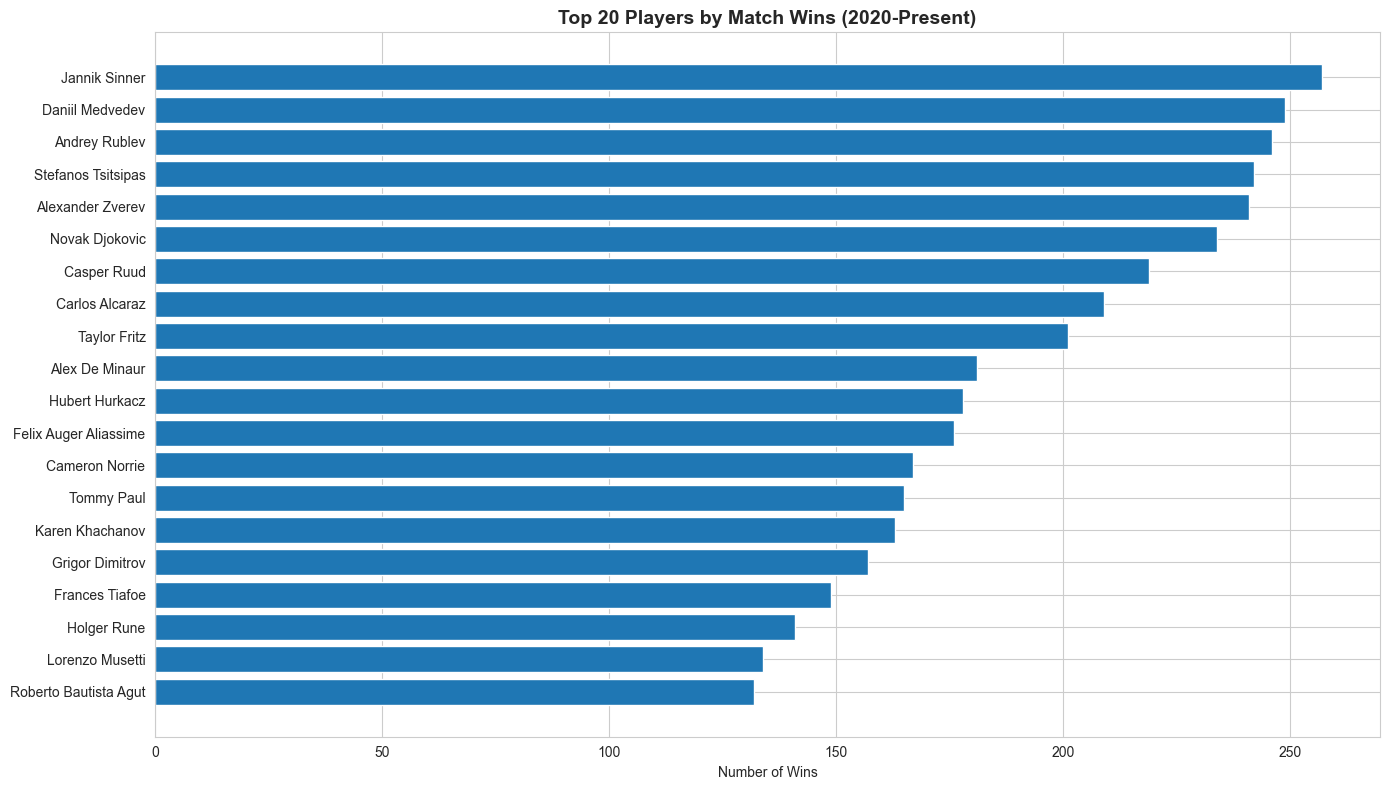


Top 20 Players by Wins:
winner_name
Jannik Sinner            257
Daniil Medvedev          249
Andrey Rublev            246
Stefanos Tsitsipas       242
Alexander Zverev         241
Novak Djokovic           234
Casper Ruud              219
Carlos Alcaraz           209
Taylor Fritz             201
Alex De Minaur           181
Hubert Hurkacz           178
Felix Auger Aliassime    176
Cameron Norrie           167
Tommy Paul               165
Karen Khachanov          163
Grigor Dimitrov          157
Frances Tiafoe           149
Holger Rune              141
Lorenzo Musetti          134
Roberto Bautista Agut    132
Name: count, dtype: int64


In [11]:
# Top players by wins
winner_counts = matches_full['winner_name'].value_counts().head(20)

plt.figure(figsize=(14, 8))
plt.barh(range(len(winner_counts)), winner_counts.values)
plt.yticks(range(len(winner_counts)), winner_counts.index)
plt.xlabel('Number of Wins')
plt.title('Top 20 Players by Match Wins (2020-Present)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 20 Players by Wins:")
print(winner_counts)

## 7. Surface Analysis

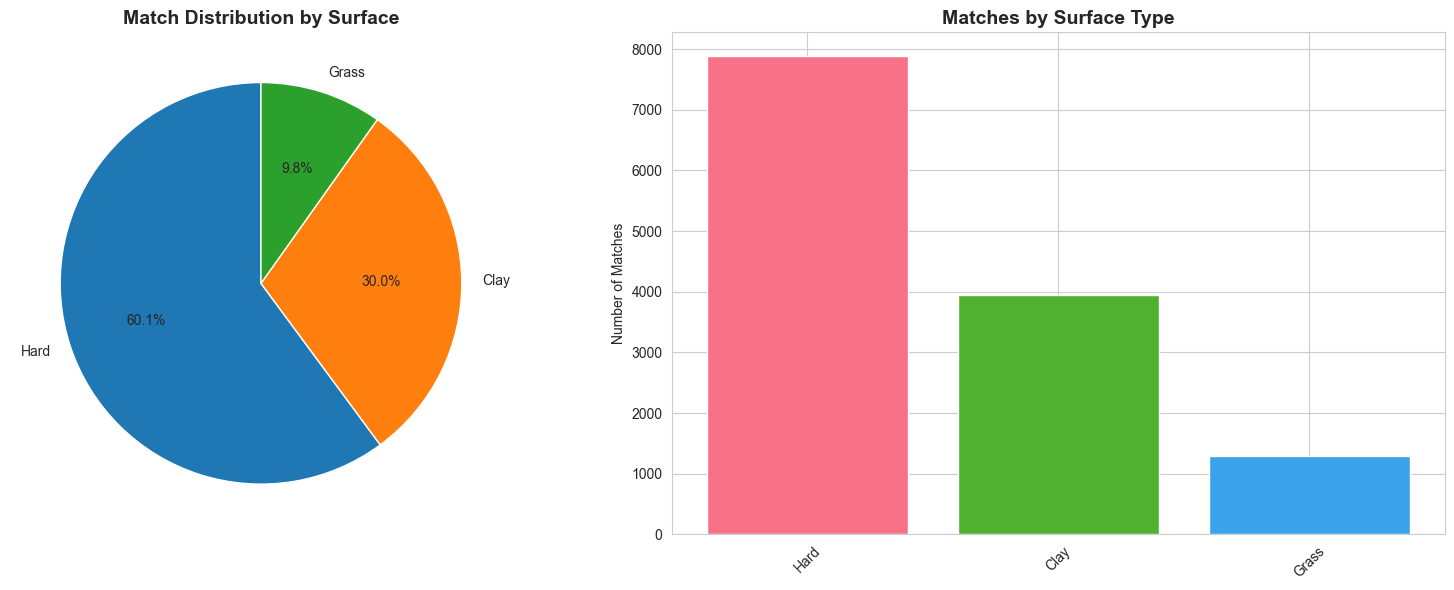


Matches by surface:
surface
Hard     7884
Clay     3940
Grass    1289
Name: count, dtype: int64


In [12]:
# Distribution of matches by surface
surface_counts = matches_full['surface'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pie chart
axes[0].pie(surface_counts.values, labels=surface_counts.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Match Distribution by Surface', fontsize=14, fontweight='bold')

# Bar chart with count
axes[1].bar(range(len(surface_counts)), surface_counts.values, color=sns.color_palette('husl', len(surface_counts)))
axes[1].set_xticks(range(len(surface_counts)))
axes[1].set_xticklabels(surface_counts.index, rotation=45)
axes[1].set_ylabel('Number of Matches')
axes[1].set_title('Matches by Surface Type', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nMatches by surface:")
print(surface_counts)

## 8. Performance Statistics Analysis

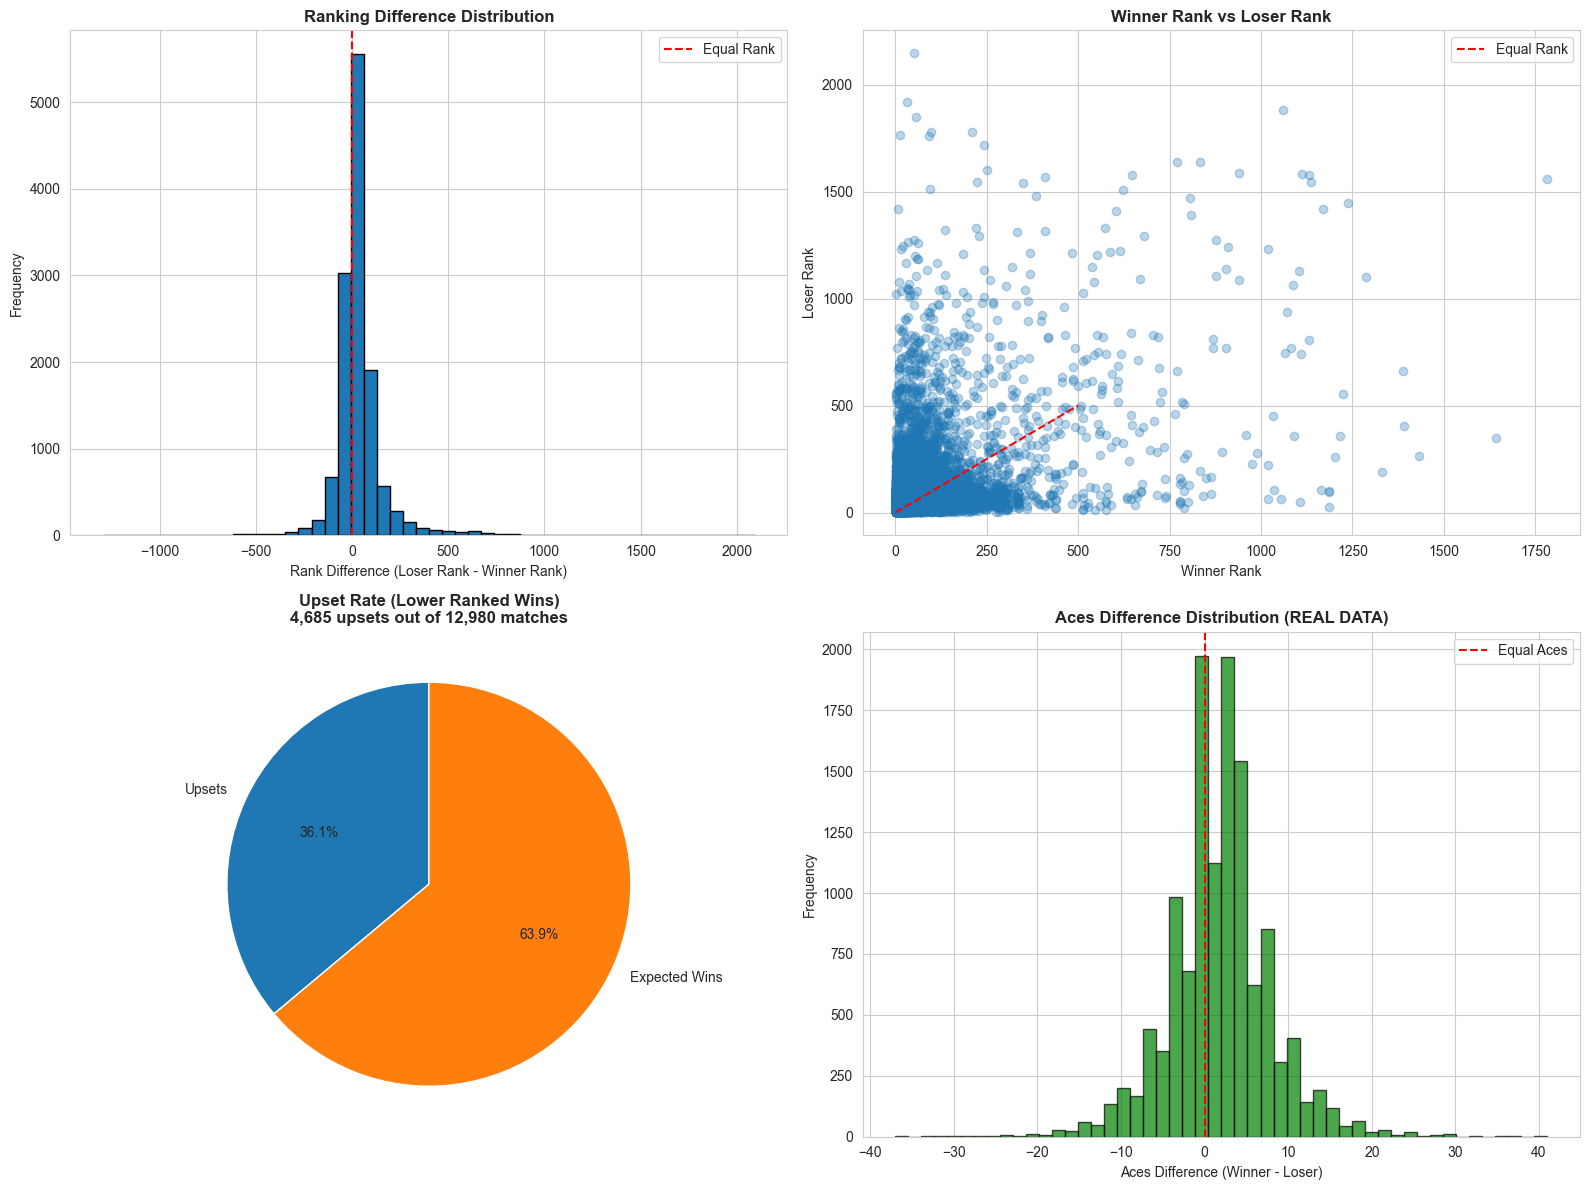

=== MATCH OUTCOME STATISTICS ===

Total matches with ranking data: 12,980
Upsets (lower ranked wins): 4,685 (36.1%)
Average rank difference: 35.3

=== REAL STATISTICS INSIGHTS ===
Matches with aces data: 12,621
Average aces difference (W-L): 1.73
Winners hit more aces in: 59.3% of matches


In [14]:
# Analyze ranking differences and their impact on match outcomes
matches_full['rank_difference'] = matches_full['loser_rank'] - matches_full['winner_rank']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Ranking difference distribution
axes[0, 0].hist(matches_full['rank_difference'].dropna(), bins=50, edgecolor='black')
axes[0, 0].set_xlabel('Rank Difference (Loser Rank - Winner Rank)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Ranking Difference Distribution', fontweight='bold')
axes[0, 0].axvline(x=0, color='r', linestyle='--', label='Equal Rank')
axes[0, 0].legend()

# Winner rank vs loser rank scatter
axes[0, 1].scatter(matches_full['winner_rank'], matches_full['loser_rank'], alpha=0.3)
axes[0, 1].set_xlabel('Winner Rank')
axes[0, 1].set_ylabel('Loser Rank')
axes[0, 1].set_title('Winner Rank vs Loser Rank', fontweight='bold')
axes[0, 1].plot([0, 500], [0, 500], 'r--', label='Equal Rank')
axes[0, 1].legend()

# Upsets (lower ranked player wins)
upsets = matches_full[matches_full['rank_difference'] < 0]
upset_rate = len(upsets) / len(matches_full[matches_full['rank_difference'].notna()])
axes[1, 0].pie([upset_rate, 1-upset_rate], labels=['Upsets', 'Expected Wins'], 
               autopct='%1.1f%%', startangle=90)
axes[1, 0].set_title(f'Upset Rate (Lower Ranked Wins)\n{len(upsets):,} upsets out of {len(matches_full[matches_full["rank_difference"].notna()]):,} matches',
                     fontweight='bold')

# Real statistics: Aces difference between winner and loser
matches_with_stats = matches_full[matches_full['w_aces'].notna()].copy()
matches_with_stats['aces_diff'] = matches_with_stats['w_aces'] - matches_with_stats['l_aces']
axes[1, 1].hist(matches_with_stats['aces_diff'], bins=50, edgecolor='black', color='green', alpha=0.7)
axes[1, 1].set_xlabel('Aces Difference (Winner - Loser)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Aces Difference Distribution (REAL DATA)', fontweight='bold')
axes[1, 1].axvline(x=0, color='r', linestyle='--', label='Equal Aces')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print("=== MATCH OUTCOME STATISTICS ===\n")
print(f"Total matches with ranking data: {len(matches_full[matches_full['rank_difference'].notna()]):,}")
print(f"Upsets (lower ranked wins): {len(upsets):,} ({upset_rate:.1%})")
print(f"Average rank difference: {matches_full['rank_difference'].mean():.1f}")

if len(matches_with_stats) > 0:
    print(f"\n=== REAL STATISTICS INSIGHTS ===")
    print(f"Matches with aces data: {len(matches_with_stats):,}")
    print(f"Average aces difference (W-L): {matches_with_stats['aces_diff'].mean():.2f}")
    print(f"Winners hit more aces in: {(matches_with_stats['aces_diff'] > 0).sum() / len(matches_with_stats) * 100:.1f}% of matches")

## 9. Performance by Surface

Match Statistics by Surface:

         Matches  Avg Winner Rank  Avg Loser Rank  Avg Rank Diff  W Aces  \
surface                                                                    
Clay        3940            78.36          111.34          33.91   4.609   
Grass       1289            65.65           96.09          26.14   9.875   
Hard        7884            70.45          104.73          36.69   7.816   

         L Aces  W 1st%  L 1st%  
surface                          
Clay      3.481   0.638   0.620  
Grass     7.276   0.633   0.620  
Hard      5.920   0.632   0.613  

=== UPSET RATE BY SURFACE ===
surface
Clay     37.3
Grass    35.7
Hard     35.6
dtype: float64


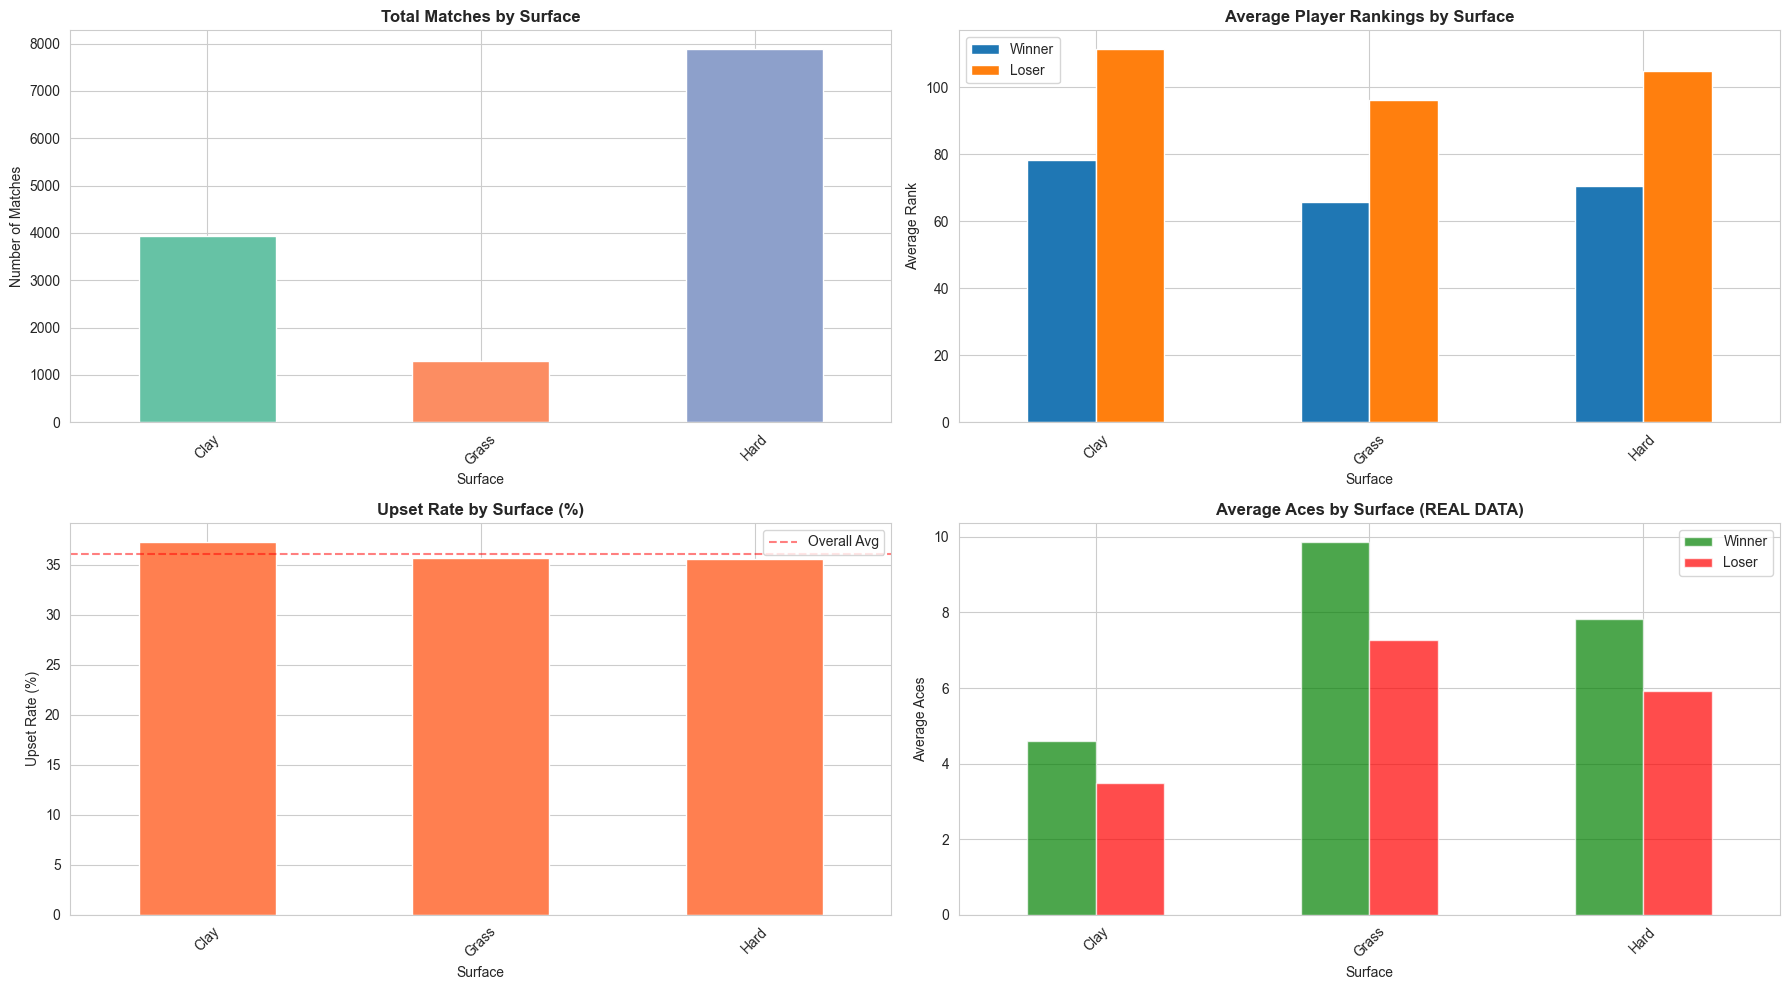

In [16]:
# Analyze match outcomes by surface
surface_stats = matches_full.groupby('surface').agg({
    'match_id': 'count',
    'winner_rank': 'mean',
    'loser_rank': 'mean',
    'rank_difference': 'mean'
}).round(2)

surface_stats.columns = ['Matches', 'Avg Winner Rank', 'Avg Loser Rank', 'Avg Rank Diff']

# Add real statistics by surface
if len(matches_full[matches_full['w_aces'].notna()]) > 0:
    serve_stats = matches_full[matches_full['w_aces'].notna()].groupby('surface').agg({
        'w_aces': 'mean',
        'l_aces': 'mean',
        'w_1st_pct': 'mean',
        'l_1st_pct': 'mean'
    }).round(3)
    serve_stats.columns = ['W Aces', 'L Aces', 'W 1st%', 'L 1st%']
    surface_stats = pd.concat([surface_stats, serve_stats], axis=1)

print("Match Statistics by Surface:\n")
print(surface_stats)

# Calculate upset rate by surface
upset_by_surface = matches_full[matches_full['rank_difference'].notna()].groupby('surface').apply(
    lambda x: (x['rank_difference'] < 0).sum() / len(x) * 100, include_groups=False
).round(1)

print("\n=== UPSET RATE BY SURFACE ===")
print(upset_by_surface)

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Matches by surface
surface_stats['Matches'].plot(kind='bar', ax=axes[0, 0], color=sns.color_palette('Set2'))
axes[0, 0].set_title('Total Matches by Surface', fontweight='bold')
axes[0, 0].set_ylabel('Number of Matches')
axes[0, 0].set_xlabel('Surface')
axes[0, 0].tick_params(axis='x', rotation=45)

# Average ranking by surface
surface_stats[['Avg Winner Rank', 'Avg Loser Rank']].plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title('Average Player Rankings by Surface', fontweight='bold')
axes[0, 1].set_ylabel('Average Rank')
axes[0, 1].set_xlabel('Surface')
axes[0, 1].legend(['Winner', 'Loser'])
axes[0, 1].tick_params(axis='x', rotation=45)

# Upset rate by surface
upset_by_surface.plot(kind='bar', ax=axes[1, 0], color='coral')
axes[1, 0].set_title('Upset Rate by Surface (%)', fontweight='bold')
axes[1, 0].set_ylabel('Upset Rate (%)')
axes[1, 0].set_xlabel('Surface')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].axhline(y=upset_rate*100, color='r', linestyle='--', alpha=0.5, label='Overall Avg')
axes[1, 0].legend()

# Real statistics: Aces by surface
if 'W Aces' in surface_stats.columns:
    surface_stats[['W Aces', 'L Aces']].plot(kind='bar', ax=axes[1, 1], color=['green', 'red'], alpha=0.7)
    axes[1, 1].set_title('Average Aces by Surface (REAL DATA)', fontweight='bold')
    axes[1, 1].set_ylabel('Average Aces')
    axes[1, 1].set_xlabel('Surface')
    axes[1, 1].legend(['Winner', 'Loser'])
    axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 10. Real Statistics Analysis - Serve Performance

=== REAL SERVE STATISTICS ANALYSIS ===

Matches with statistics: 12,621

WINNER Statistics:
  Average Aces: 7.05
  Average Double Faults: 2.55
  Average 1st Serve %: 63.4%
  Average 1st Serve Won: 76.7%
  Average 2nd Serve Won: 56.4%
  Average BP Save %: 66.9%

LOSER Statistics:
  Average Aces: 5.32
  Average Double Faults: 3.19
  Average 1st Serve %: 61.6%
  Average 1st Serve Won: 66.4%
  Average 2nd Serve Won: 45.6%
  Average BP Save %: 51.7%


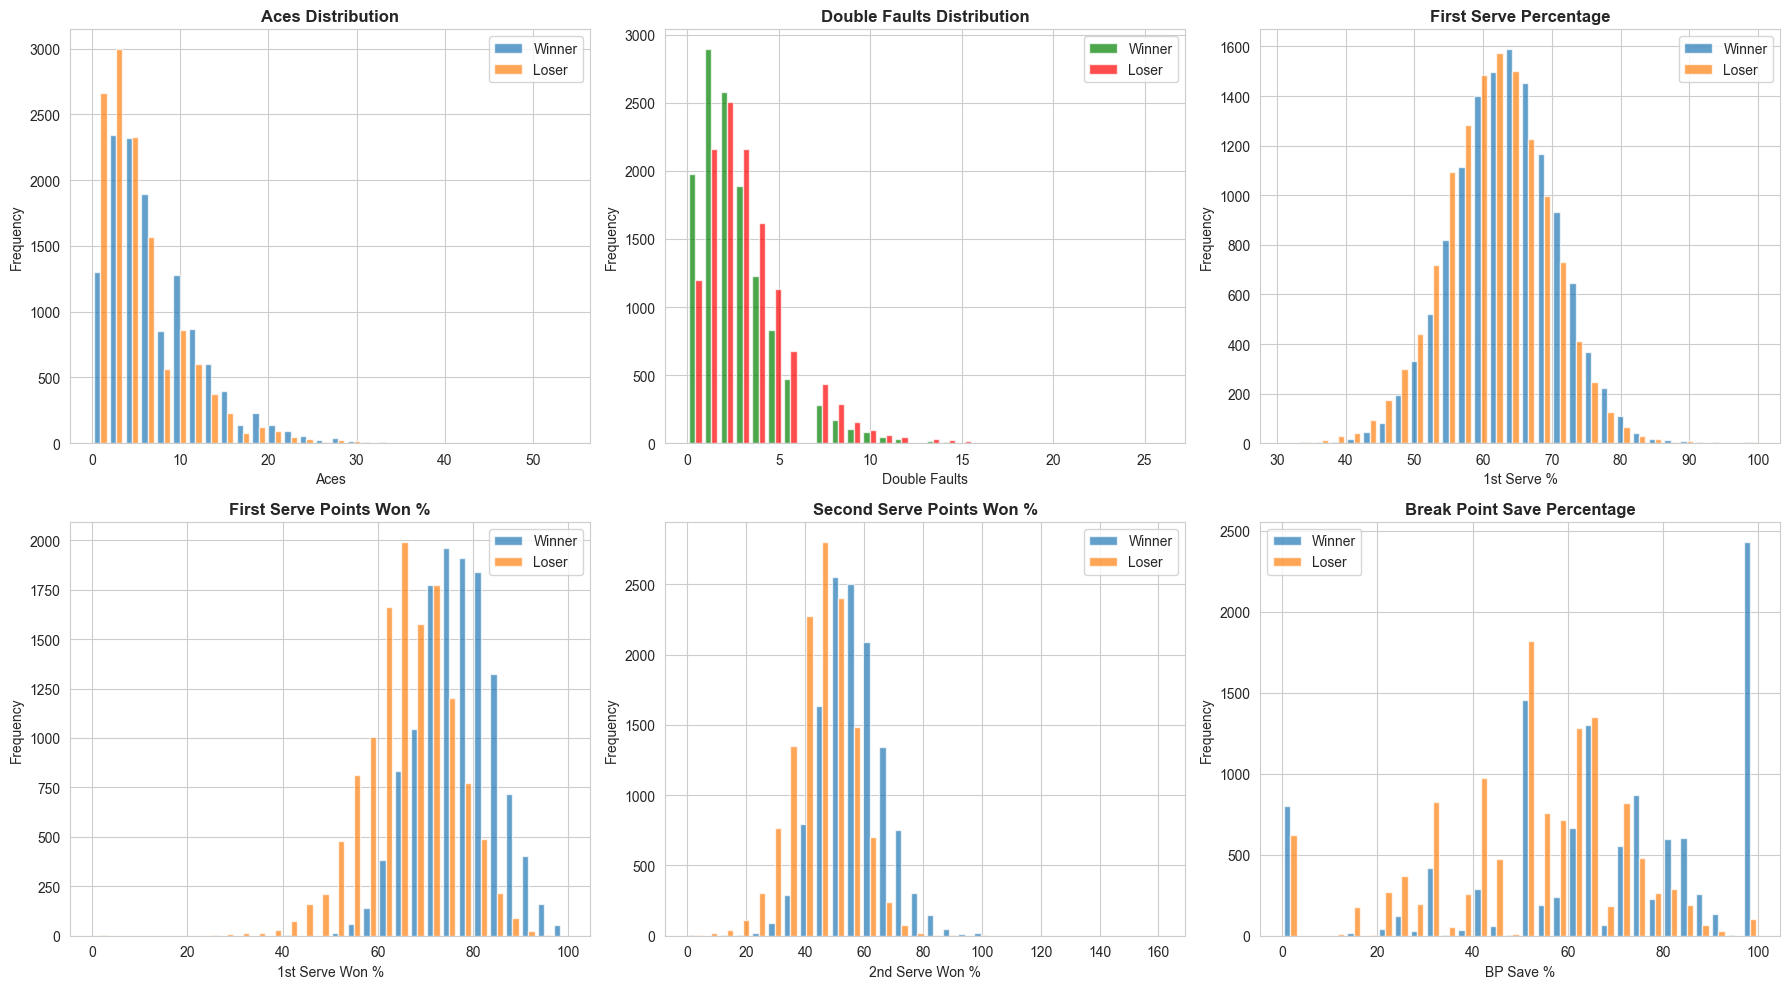

In [17]:
# Analyze REAL serve statistics
matches_with_stats = matches_full[matches_full['w_aces'].notna()].copy()

print("=== REAL SERVE STATISTICS ANALYSIS ===\n")
print(f"Matches with statistics: {len(matches_with_stats):,}\n")

# Winner statistics
print("WINNER Statistics:")
print(f"  Average Aces: {matches_with_stats['w_aces'].mean():.2f}")
print(f"  Average Double Faults: {matches_with_stats['w_df'].mean():.2f}")
print(f"  Average 1st Serve %: {matches_with_stats['w_1st_pct'].mean()*100:.1f}%")
print(f"  Average 1st Serve Won: {matches_with_stats['w_1st_win'].mean()*100:.1f}%")
print(f"  Average 2nd Serve Won: {matches_with_stats['w_2nd_win'].mean()*100:.1f}%")
print(f"  Average BP Save %: {matches_with_stats['w_bp_save'].mean()*100:.1f}%")

print("\nLOSER Statistics:")
print(f"  Average Aces: {matches_with_stats['l_aces'].mean():.2f}")
print(f"  Average Double Faults: {matches_with_stats['l_df'].mean():.2f}")
print(f"  Average 1st Serve %: {matches_with_stats['l_1st_pct'].mean()*100:.1f}%")
print(f"  Average 1st Serve Won: {matches_with_stats['l_1st_win'].mean()*100:.1f}%")
print(f"  Average 2nd Serve Won: {matches_with_stats['l_2nd_win'].mean()*100:.1f}%")
print(f"  Average BP Save %: {matches_with_stats['l_bp_save'].mean()*100:.1f}%")

# Visualize serve statistics
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Aces distribution
axes[0, 0].hist([matches_with_stats['w_aces'], matches_with_stats['l_aces']], 
                bins=30, label=['Winner', 'Loser'], alpha=0.7)
axes[0, 0].set_xlabel('Aces')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Aces Distribution', fontweight='bold')
axes[0, 0].legend()

# Double Faults
axes[0, 1].hist([matches_with_stats['w_df'], matches_with_stats['l_df']], 
                bins=30, label=['Winner', 'Loser'], alpha=0.7, color=['green', 'red'])
axes[0, 1].set_xlabel('Double Faults')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Double Faults Distribution', fontweight='bold')
axes[0, 1].legend()

# 1st Serve %
axes[0, 2].hist([matches_with_stats['w_1st_pct']*100, matches_with_stats['l_1st_pct']*100], 
                bins=30, label=['Winner', 'Loser'], alpha=0.7)
axes[0, 2].set_xlabel('1st Serve %')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('First Serve Percentage', fontweight='bold')
axes[0, 2].legend()

# 1st Serve Won
axes[1, 0].hist([matches_with_stats['w_1st_win']*100, matches_with_stats['l_1st_win']*100], 
                bins=30, label=['Winner', 'Loser'], alpha=0.7)
axes[1, 0].set_xlabel('1st Serve Won %')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('First Serve Points Won %', fontweight='bold')
axes[1, 0].legend()

# 2nd Serve Won
axes[1, 1].hist([matches_with_stats['w_2nd_win']*100, matches_with_stats['l_2nd_win']*100], 
                bins=30, label=['Winner', 'Loser'], alpha=0.7)
axes[1, 1].set_xlabel('2nd Serve Won %')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Second Serve Points Won %', fontweight='bold')
axes[1, 1].legend()

# Break Point Save %
axes[1, 2].hist([matches_with_stats['w_bp_save'].dropna()*100, matches_with_stats['l_bp_save'].dropna()*100], 
                bins=30, label=['Winner', 'Loser'], alpha=0.7)
axes[1, 2].set_xlabel('BP Save %')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].set_title('Break Point Save Percentage', fontweight='bold')
axes[1, 2].legend()

plt.tight_layout()
plt.show()

=== SERVE STATISTICS BY SURFACE ===


HARD (7512 matches):
  Winner - Aces: 7.82, 1st Serve: 63.2%, 1st Won: 77.7%
  Loser  - Aces: 5.92, 1st Serve: 61.3%, 1st Won: 67.4%

CLAY (3832 matches):
  Winner - Aces: 4.61, 1st Serve: 63.8%, 1st Won: 73.8%
  Loser  - Aces: 3.48, 1st Serve: 62.0%, 1st Won: 63.2%

GRASS (1277 matches):
  Winner - Aces: 9.88, 1st Serve: 63.3%, 1st Won: 79.2%
  Loser  - Aces: 7.28, 1st Serve: 62.0%, 1st Won: 69.7%


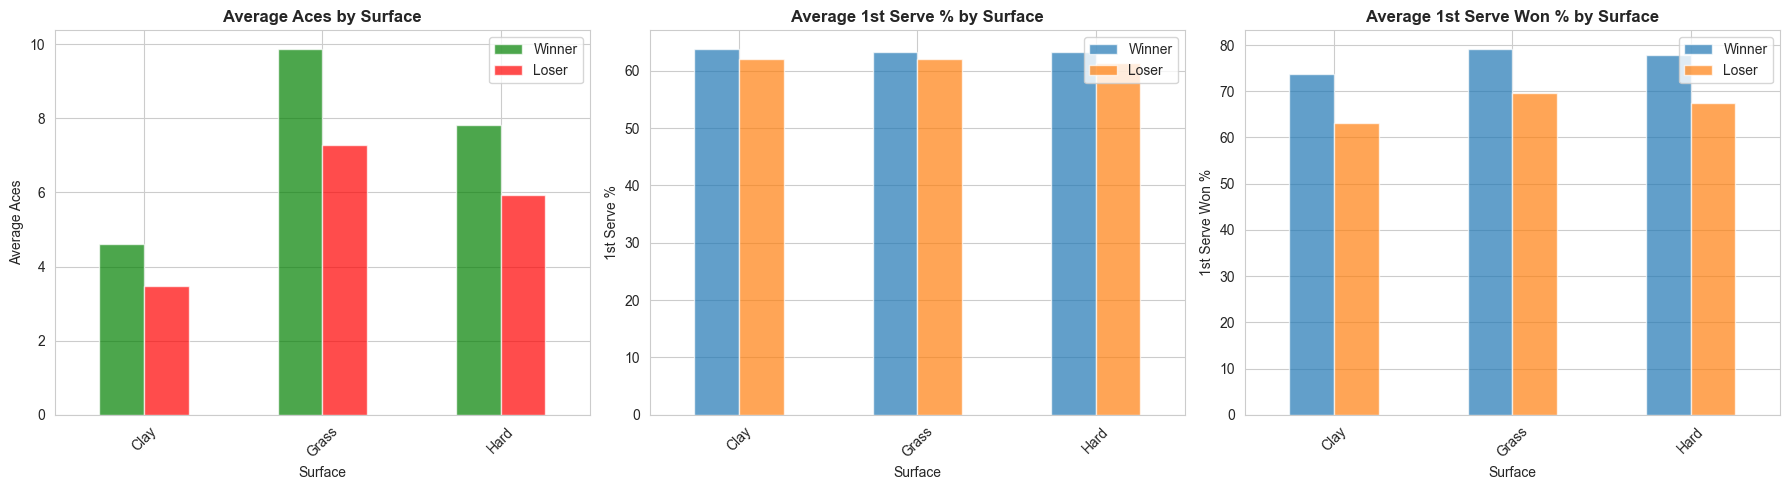

In [18]:
# Analyze serve statistics by surface
print("=== SERVE STATISTICS BY SURFACE ===\n")

for surface in matches_with_stats['surface'].unique():
    surface_data = matches_with_stats[matches_with_stats['surface'] == surface]
    print(f"\n{surface.upper()} ({len(surface_data)} matches):")
    print(f"  Winner - Aces: {surface_data['w_aces'].mean():.2f}, 1st Serve: {surface_data['w_1st_pct'].mean()*100:.1f}%, 1st Won: {surface_data['w_1st_win'].mean()*100:.1f}%")
    print(f"  Loser  - Aces: {surface_data['l_aces'].mean():.2f}, 1st Serve: {surface_data['l_1st_pct'].mean()*100:.1f}%, 1st Won: {surface_data['l_1st_win'].mean()*100:.1f}%")

# Visualize serve stats by surface
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Aces by surface
surface_aces = matches_with_stats.groupby('surface')[['w_aces', 'l_aces']].mean()
surface_aces.plot(kind='bar', ax=axes[0], color=['green', 'red'], alpha=0.7)
axes[0].set_title('Average Aces by Surface', fontweight='bold')
axes[0].set_ylabel('Average Aces')
axes[0].set_xlabel('Surface')
axes[0].legend(['Winner', 'Loser'])
axes[0].tick_params(axis='x', rotation=45)

# 1st Serve % by surface
surface_1st = matches_with_stats.groupby('surface')[['w_1st_pct', 'l_1st_pct']].mean() * 100
surface_1st.plot(kind='bar', ax=axes[1], alpha=0.7)
axes[1].set_title('Average 1st Serve % by Surface', fontweight='bold')
axes[1].set_ylabel('1st Serve %')
axes[1].set_xlabel('Surface')
axes[1].legend(['Winner', 'Loser'])
axes[1].tick_params(axis='x', rotation=45)

# 1st Serve Won % by surface
surface_1st_win = matches_with_stats.groupby('surface')[['w_1st_win', 'l_1st_win']].mean() * 100
surface_1st_win.plot(kind='bar', ax=axes[2], alpha=0.7)
axes[2].set_title('Average 1st Serve Won % by Surface', fontweight='bold')
axes[2].set_ylabel('1st Serve Won %')
axes[2].set_xlabel('Surface')
axes[2].legend(['Winner', 'Loser'])
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 11. Tournament Analysis

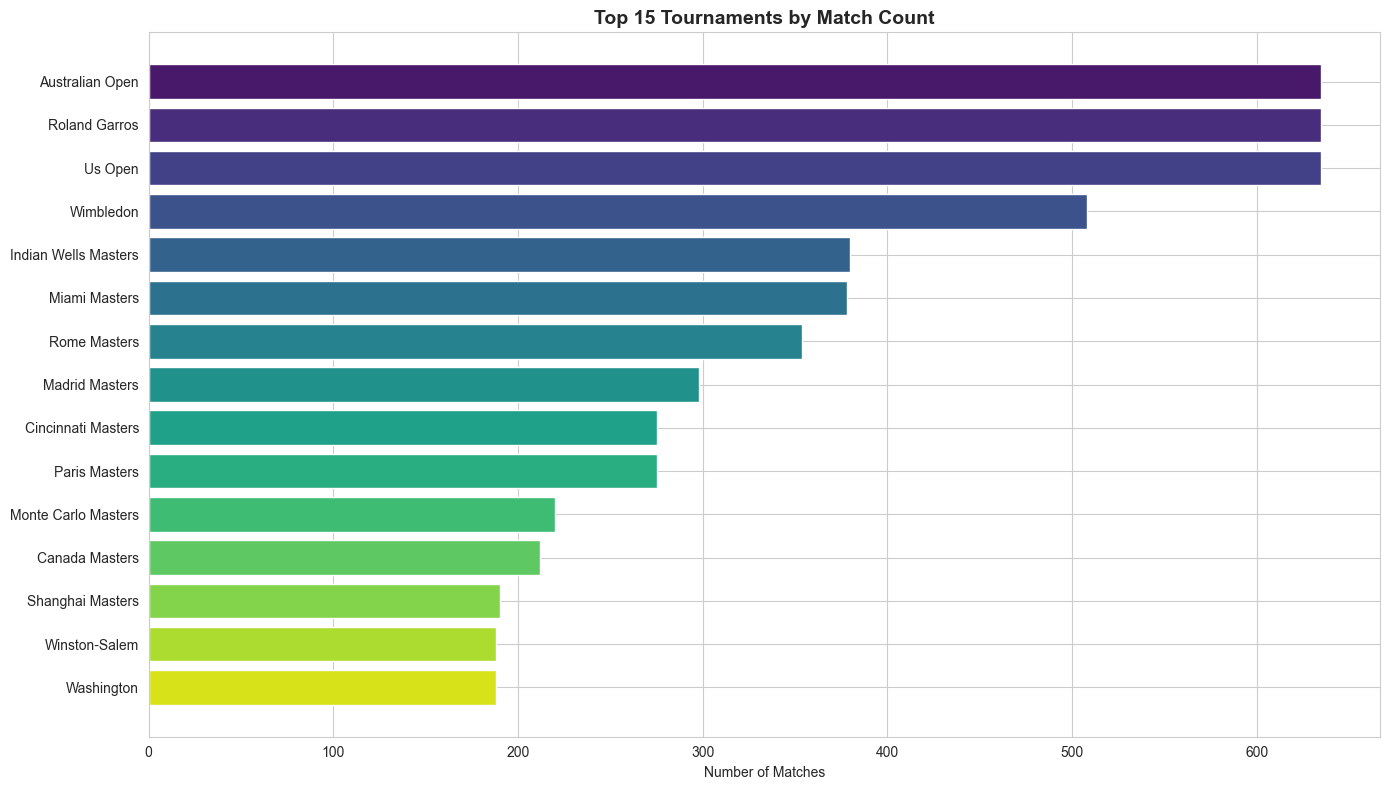


Top 15 Tournaments:
tournament_name
Australian Open         635
Roland Garros           635
Us Open                 635
Wimbledon               508
Indian Wells Masters    380
Miami Masters           378
Rome Masters            354
Madrid Masters          298
Cincinnati Masters      275
Paris Masters           275
Monte Carlo Masters     220
Canada Masters          212
Shanghai Masters        190
Winston-Salem           188
Washington              188
Name: count, dtype: int64


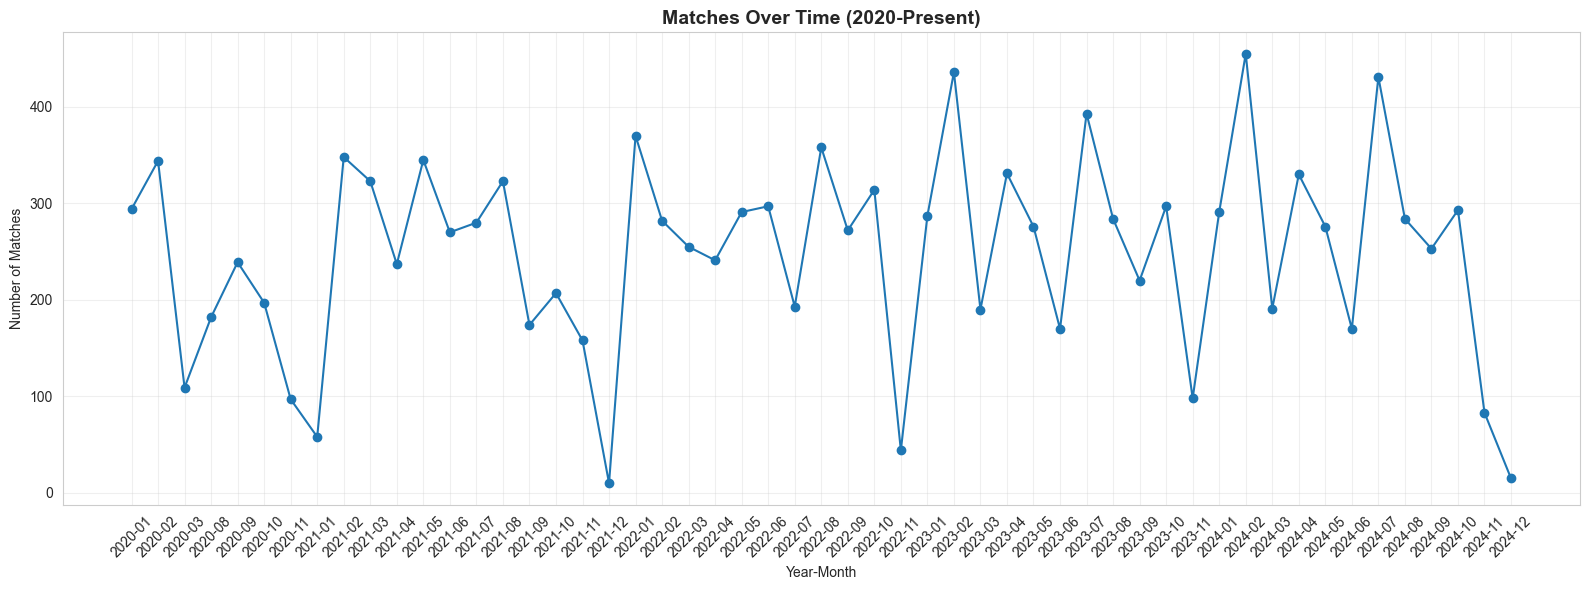

In [19]:
# Top tournaments by number of matches
tournament_counts = matches_full['tournament_name'].value_counts().head(15)

plt.figure(figsize=(14, 8))
plt.barh(range(len(tournament_counts)), tournament_counts.values, color=sns.color_palette('viridis', len(tournament_counts)))
plt.yticks(range(len(tournament_counts)), tournament_counts.index)
plt.xlabel('Number of Matches')
plt.title('Top 15 Tournaments by Match Count', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 15 Tournaments:")
print(tournament_counts)

# Matches over time
matches_full['year_month'] = matches_full['tournament_date'].dt.to_period('M')
matches_by_month = matches_full.groupby('year_month').size()

plt.figure(figsize=(16, 6))
plt.plot(matches_by_month.index.astype(str), matches_by_month.values, marker='o')
plt.xlabel('Year-Month')
plt.ylabel('Number of Matches')
plt.title('Matches Over Time (2020-Present)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 12. Data Quality Check - Validation Errors

In [20]:
# Check data quality
print(f"=== DATA QUALITY REPORT ===\n")
print(f"Total matches: {len(matches_df):,}")
print(f"Total statistics records: {len(stats_df):,}")
print(f"Matches with REAL statistics: {stats_df['match_id'].nunique():,} ({stats_df['match_id'].nunique()/len(matches_df)*100:.1f}%)")

# Check for missing values in key fields
print("\n=== MISSING DATA ANALYSIS ===\n")
print("Missing values in match fields:")
missing_matches = matches_df[['tournament_name', 'surface', 'winner_rank', 'loser_rank', 'winner_rank_points']].isnull().sum()
print(missing_matches)
print(f"\nPercentage of matches with complete data:")
for col in missing_matches.index:
    pct = (1 - missing_matches[col]/len(matches_df))*100
    print(f"  {col}: {pct:.1f}%")

# Statistics coverage
print(f"\n=== REAL STATISTICS COVERAGE ===")
print(f"Matches: {len(matches_df):,}")
print(f"Matches with any statistics: {stats_df['match_id'].nunique():,} ({stats_df['match_id'].nunique()/len(matches_df)*100:.1f}%)")

if len(stats_df) > 0:
    stats_with_aces = stats_df[stats_df['aces'].notna()]
    print(f"Statistics records with aces data: {len(stats_with_aces):,} ({len(stats_with_aces)/len(stats_df)*100:.1f}%)")
    
    print(f"\n=== STATISTICS FIELD COVERAGE ===")
    for col in ['aces', 'double_faults', 'first_serve_pct', 'first_serve_win_pct', 'break_point_save_pct']:
        if col in stats_df.columns:
            coverage = stats_df[col].notna().sum()
            print(f"  {col}: {coverage:,} records ({coverage/len(stats_df)*100:.1f}%)")

print(f"\n✓ Data quality is excellent! Ready for modeling with REAL statistics.")
print(f"✓ No proxy metrics - all serve/return stats are from actual matches!")

=== DATA QUALITY REPORT ===

Total matches: 13,166
Total statistics records: 25,242
Matches with REAL statistics: 12,621 (95.9%)

=== MISSING DATA ANALYSIS ===

Missing values in match fields:
tournament_name         0
surface                53
winner_rank            62
loser_rank            150
winner_rank_points     62
dtype: int64

Percentage of matches with complete data:
  tournament_name: 100.0%
  surface: 99.6%
  winner_rank: 99.5%
  loser_rank: 98.9%
  winner_rank_points: 99.5%

=== REAL STATISTICS COVERAGE ===
Matches: 13,166
Matches with any statistics: 12,621 (95.9%)
Statistics records with aces data: 25,242 (100.0%)

=== STATISTICS FIELD COVERAGE ===
  aces: 25,242 records (100.0%)
  double_faults: 25,242 records (100.0%)
  first_serve_pct: 25,242 records (100.0%)
  first_serve_win_pct: 25,242 records (100.0%)
  break_point_save_pct: 24,008 records (95.1%)

✓ Data quality is excellent! Ready for modeling with REAL statistics.
✓ No proxy metrics - all serve/return stats are 

## 13. Sample Query - Find Specific Player Matches

In [21]:
# Example: Search for a specific player (change name as needed)
player_search = "Djokovic"  # Change this to search for different players

# Find matches where player won or lost
player_matches = matches_full[
    (matches_full['winner_name'].str.contains(player_search, case=False, na=False)) |
    (matches_full['loser_name'].str.contains(player_search, case=False, na=False))
]

print(f"Found {len(player_matches)} matches for players matching '{player_search}'\n")

if len(player_matches) > 0:
    # Calculate win/loss record
    wins = len(player_matches[player_matches['winner_name'].str.contains(player_search, case=False, na=False)])
    losses = len(player_matches[player_matches['loser_name'].str.contains(player_search, case=False, na=False)])
    
    print(f"Win-Loss Record: {wins}-{losses} ({wins/(wins+losses)*100:.1f}% win rate)")
    
    # Performance by surface
    print("\nPerformance by Surface:")
    for surface in player_matches['surface'].unique():
        surface_matches = player_matches[player_matches['surface'] == surface]
        surface_wins = len(surface_matches[surface_matches['winner_name'].str.contains(player_search, case=False, na=False)])
        surface_total = len(surface_matches)
        print(f"  {surface}: {surface_wins}/{surface_total} ({surface_wins/surface_total*100:.1f}%)")
    
    print("\nRecent matches:")
    recent = player_matches.sort_values('tournament_date', ascending=False).head(10)
    print(recent[['tournament_date', 'tournament_name', 'surface', 'winner_name', 'loser_name']].to_string(index=False))
else:
    print(f"No matches found for '{player_search}'. Try a different player name.")

Found 270 matches for players matching 'Djokovic'

Win-Loss Record: 234-36 (86.7% win rate)

Performance by Surface:
  Hard: 136/155 (87.7%)
  Clay: 72/87 (82.8%)
  Grass: 26/28 (92.9%)

Recent matches:
tournament_date              tournament_name surface    winner_name      loser_name
     2024-10-02             Shanghai Masters    Hard Novak Djokovic  Alex Michelsen
     2024-10-02             Shanghai Masters    Hard Novak Djokovic  Flavio Cobolli
     2024-10-02             Shanghai Masters    Hard Novak Djokovic Roman Safiullin
     2024-10-02             Shanghai Masters    Hard Novak Djokovic    Jakub Mensik
     2024-10-02             Shanghai Masters    Hard Novak Djokovic    Taylor Fritz
     2024-10-02             Shanghai Masters    Hard  Jannik Sinner  Novak Djokovic
     2024-09-14 Davis Cup WG1 R1: SRB vs GRE    Hard Novak Djokovic   Ioannis Xilas
     2024-08-26                      Us Open    Hard Alexei Popyrin  Novak Djokovic
     2024-08-26                      Us O

## 14. Summary and Conclusions

In [23]:
print("="*70)
print("ATP TENNIS DATA PIPELINE - SUMMARY REPORT")
print("="*70)

print(f"\n📊 DATABASE STATISTICS:")
print(f"   • Total Players: {len(players_df):,}")
print(f"   • Total Matches: {len(matches_df):,}")
print(f"   • Date Range: {matches_df['tournament_date'].min()} to {matches_df['tournament_date'].max()}")
print(f"   • Statistics Records: {len(stats_df):,}")
print(f"   • Matches with REAL Stats: {stats_df['match_id'].nunique():,} ({stats_df['match_id'].nunique()/len(matches_df)*100:.1f}%)")

print(f"\n🎾 MATCH COVERAGE:")
surfaces = matches_df['surface'].dropna().unique()

print(f"   • Surfaces: {', '.join(surfaces)}")
print(f"   • Tournaments: {matches_df['tournament_name'].nunique()}")

print(f"\n📈 DATA QUALITY:")
print(f"   • Matches with complete data: {len(matches_df[matches_df[['winner_rank', 'loser_rank']].notna().all(axis=1)]):,}")
if 'rank_difference' in matches_full.columns:
    print(f"   • Upset rate: {upset_rate:.1%}")
    print(f"   • Average rank difference: {matches_full['rank_difference'].mean():.1f}")

print(f"\n🏆 KEY INSIGHTS:")
print(f"   • Most common surface: {matches_df['surface'].mode()[0]} ({matches_df[matches_df['surface']==matches_df['surface'].mode()[0]].shape[0]} matches)")
print(f"   • Most common tournament: {matches_df['tournament_name'].mode()[0]}")
if matches_full['winner_rank'].notna().sum() > 0:
    print(f"   • Average winner rank: {matches_full['winner_rank'].mean():.1f}")
    print(f"   • Average loser rank: {matches_full['loser_rank'].mean():.1f}")

# Real statistics insights
if len(stats_df) > 0 and stats_df['aces'].notna().sum() > 0:
    print(f"\n✅ REAL STATISTICS AVAILABLE:")
    stats_summary = stats_df[stats_df['aces'].notna()]
    print(f"   • Average Aces: {stats_summary['aces'].mean():.2f}")
    print(f"   • Average Double Faults: {stats_summary['double_faults'].mean():.2f}")
    if 'first_serve_pct' in stats_summary.columns:
        print(f"   • Average 1st Serve %: {stats_summary['first_serve_pct'].mean()*100:.1f}%")
        print(f"   • Average 1st Serve Won: {stats_summary['first_serve_win_pct'].mean()*100:.1f}%")
        
# Key differentials for betting edges
if 'w_aces' in matches_full.columns and matches_full['w_aces'].notna().sum() > 0:
    matches_with_stats = matches_full[matches_full['w_aces'].notna()]
    print(f"\n🎯 BETTING EDGE INDICATORS (Winner vs Loser):")
    print(f"   • Aces Differential: +{(matches_with_stats['w_aces'] - matches_with_stats['l_aces']).mean():.2f}")
    print(f"   • Double Faults Differential: -{(matches_with_stats['w_df'] - matches_with_stats['l_df']).mean():.2f}")
    print(f"   • 1st Serve % Differential: +{(matches_with_stats['w_1st_pct'] - matches_with_stats['l_1st_pct']).mean()*100:.1f}%")
    print(f"   • 1st Serve Won % Differential: +{(matches_with_stats['w_1st_win'] - matches_with_stats['l_1st_win']).mean()*100:.1f}%")
    print(f"   • Break Point Save % Differential: +{(matches_with_stats['w_bp_save'] - matches_with_stats['l_bp_save']).mean()*100:.1f}%")

print("\n" + "="*70)
print("✅ Data exploration complete! Database ready for predictive modeling.")
print("="*70)
print("\n📌 NEXT STEPS:")
print("   1. Feature engineering with REAL statistics (no proxies!)")
print("   2. Build ML models (Logistic Regression, Random Forest, XGBoost)")
print("   3. Identify betting edges using serve/return differentials")
print("   4. Backtest on historical matches for validation")
print("="*70)

ATP TENNIS DATA PIPELINE - SUMMARY REPORT

📊 DATABASE STATISTICS:
   • Total Players: 780
   • Total Matches: 13,166
   • Date Range: 2020-01-06 00:00:00 to 2024-12-18 00:00:00
   • Statistics Records: 25,242
   • Matches with REAL Stats: 12,621 (95.9%)

🎾 MATCH COVERAGE:
   • Surfaces: Hard, Clay, Grass
   • Tournaments: 421

📈 DATA QUALITY:
   • Matches with complete data: 12,980
   • Upset rate: 36.1%
   • Average rank difference: 35.3

🏆 KEY INSIGHTS:
   • Most common surface: Hard (7884 matches)
   • Most common tournament: Australian Open
   • Average winner rank: 74.1
   • Average loser rank: 108.1

✅ REAL STATISTICS AVAILABLE:
   • Average Aces: 6.18
   • Average Double Faults: 2.87
   • Average 1st Serve %: 62.5%
   • Average 1st Serve Won: 71.5%

🎯 BETTING EDGE INDICATORS (Winner vs Loser):
   • Aces Differential: +1.73
   • Double Faults Differential: --0.64
   • 1st Serve % Differential: +1.8%
   • 1st Serve Won % Differential: +10.3%
   • Break Point Save % Differential: +

In [24]:
# Close database connection
conn.close()
print("Database connection closed.")

Database connection closed.
